# Frozen Lake


#### import all requirements

In [1]:
import gym

In [2]:
import pandas as pd
import time
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import random

#### register 4x4 environment

In [4]:
from gym.envs.registration import register
register(
    id='FrozenLakeNotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
)


In [5]:

env = gym.make('FrozenLakeNotSlippery-v0')

# Instantiate the Environment.
# env = gym.make('FrozenLake-v0')

# To check all environments present in OpenAI
# print(envs.registry.all())

# visualize 4x4 frozen lake
env.render()


SFFF
FHFH
FFFH
HFFG


In [6]:
# Total number of States and Actions
n_states = env.observation_space.n
n_actions = env.action_space.n
n_rows = int(np.sqrt(n_states))
n_cols = int(np.sqrt(n_states))
print( "States = ", n_states)
print( "Actions = ", n_actions)
print('Rows = ', n_rows)
print('Cols = ', n_cols)

States =  16
Actions =  4
Rows =  4
Cols =  4


In [7]:
##assign index to each state using state-matrix

state_matrix = np.arange(0,n_states).reshape(n_rows,n_cols)

def rowsandcols(state):
  ''' input: state returned by env
      output: location of state as (row,col) tuple'''
  return int(np.where(state_matrix ==state)[0]), int(np.where(state_matrix ==state)[1])

In [8]:
def choose_random_action(state): 

    ''' input:
      state = state returned by env.
      output = a random action depending on 
      whether the state is an edge/ corner or landlocked tile'''
      # 0 is left, 1 is down, 2 is right, 3 is up 

    k = np.arange(1, (n_rows-1))
   ##corner points    
    if rowsandcols(state)==( 0,0):
      action = random.choice([1,2])
    elif rowsandcols(state) ==(0,n_cols -1):
      action = random.choice([0,1])
    elif rowsandcols(state)==(n_rows -1 , 0):
      action = random.choice([2,3])
    elif rowsandcols(state)==(n_rows -1 , n_cols -1 ):
      action = random.choice([0,3])
    ## no action needed to be chosen for (3,3) -- terminal state 

    ##edge tiles
    elif rowsandcols(state)[0] == 0 and rowsandcols(state)[1] in k:
      action = random.choice([0,1,2])
    elif rowsandcols(state)[0] in k and rowsandcols(state)[1]  == 0:
      action = random.choice([1,2,3])
    elif rowsandcols(state)[0] in k and rowsandcols(state)[1] == n_cols -1:
      action = random.choice([0,1,3])
    elif rowsandcols(state)[0] == n_rows -1 or rowsandcols(state)[1] in k :
      action = random.choice([0,2,3])
  
  #landlocked
    else:
      action = env.action_space.sample()
    
    return action

In [17]:
def choose_max_action(state, Q):
    ''' input:
      state = state returned by env.
      Q = current Q-table
      output = argmax of max q-val for a state '''

    k = np.arange(1, (n_rows-1))

   ##corner points    
    if rowsandcols(state) == (0,0):
      action = Q.loc[state][[1,2]].idxmax(axis = 1)


    elif rowsandcols(state) ==(0,n_cols -1):
      action = int(Q.loc[state][[0,1]].idxmax(axis = 1))

    elif rowsandcols(state)==(n_rows -1 , 0):
      action = int(Q.loc[state][[2,3]].idxmax(axis = 1))

    elif state == (n_states -1):
      action = int(Q.loc[state][[0,3]].idxmax(axis = 1))

    ## no action needed to be chosen for (3,3) -- terminal state 

    ##edge tiles
    elif rowsandcols(state)[0] == 0 and rowsandcols(state)[1] in k:
      action = int(Q.loc[state][[0,1,2]].idxmax(axis = 1))

    elif rowsandcols(state)[0] in k and rowsandcols(state)[1]  == 0:
      action = int(Q.loc[state][[1,2,3]].idxmax(axis = 1))

    elif rowsandcols(state)[0] in k and rowsandcols(state)[1] == (n_cols -1):
      action = int(Q.loc[state][[0,1,3]].idxmax(axis = 1))

    elif rowsandcols(state)[0] == (n_rows -1) or rowsandcols(state)[1] in k :
      action = int(Q.loc[state][[0,2,3]].idxmax(axis = 1))
      
    else:
      action = int(Q.loc[state].idxmax(axis = 1))
    
    return action

#### Initialize Q-table

In [14]:
#Q = pd.DataFrame(np.random.rand(15,4)*(1/100))
#Q = Q.append(pd.DataFrame(np.zeros((1,4))), ignore_index = True)

Q = pd.DataFrame(np.zeros((n_states,n_actions)))
Q

,0,1,2,3
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0


In [15]:
rowsandcols(11)

(2, 3)

### Hyperparams


In [16]:
# Start with 80% random actions to explore the environment
# exploration decays with each timestep by a factor of 0.999 until it hits 10% exploration rate 

epsilon = 0.80
epsilon_final = 0.01
epsilon_decay = 0.99

gamma = 0.90 # discount factor
learning_rate = 0.9 #how important is the difference between q-val from q-table and what's observed

In [18]:
num_episodes = 1000
steps_total = [] # store number of steps taken in each episode
rewards_total = [] #store reward obtained for each episode
epsilon_total = [] #store epsilon obtained at the end of each episode

## q learning

In [19]:
for i_episode in range(num_episodes):
    
    # resets the environment
    state = env.reset()
    step = 0

    while True:
        
        step += 1
        
        
        ## generating a random num
        random_for_epsilon = np.random.rand()
        
        ## if random num lesser or equal to epsilon, then select random action
        if random_for_epsilon <= epsilon:     
            action = env.action_space.sample() #choose_random_action(state)
        
        ## else update q-vals for given state with infitismly small random nums and select argmax(a) for Q(s,a)
        else: 
           Q.loc[state] += np.random.rand(n_actions,)/1000
           action =  np.argmax(Q.loc[state]) #choose_max_action(state, Q)  #np.argmax(Q.loc[state])    
        
        
        ## as epsilon decays with more timesteps, the prob. of selecting a random val < e decays --> more likely to exploit.     
        if epsilon > epsilon_final:
            epsilon *= epsilon_decay
        
        ## env gives reward and next state and whether we've reached terminal state upon taking a at current state.. 
        new_state, reward, done, info = env.step(action)
        ##if you want reward penalized at for each timestep
        ## reward= reward*(0.9**step) 

        # filling the Q Table - 
        Q.loc[state][action] = (1- learning_rate)*Q.loc[state][action] + learning_rate*(reward + gamma * np.max(Q.loc[new_state]))
        
        # Setting new state for next action
        state = new_state
        
        # env.render()
        
        if done:
            steps_total.append(step)
            rewards_total.append(reward)
            epsilon_total.append(epsilon)
            if i_episode % 10 == 0:
                print('Episode: {} Reward: {} Steps Taken: {} Epsilon {}'.format(i_episode,reward, step, epsilon))
            break



Episode: 0 Reward: 0.0 Steps Taken: 14 Epsilon 0.6949966502151825
Episode: 10 Reward: 0.0 Steps Taken: 13 Epsilon 0.009900794037059258
Episode: 20 Reward: 0.0 Steps Taken: 59 Epsilon 0.009900794037059258
Episode: 30 Reward: 0.0 Steps Taken: 82 Epsilon 0.009900794037059258
Episode: 40 Reward: 0.0 Steps Taken: 5 Epsilon 0.009900794037059258
Episode: 50 Reward: 0.0 Steps Taken: 8 Epsilon 0.009900794037059258
Episode: 60 Reward: 0.0 Steps Taken: 22 Epsilon 0.009900794037059258
Episode: 70 Reward: 0.0 Steps Taken: 88 Epsilon 0.009900794037059258
Episode: 80 Reward: 0.0 Steps Taken: 92 Epsilon 0.009900794037059258
Episode: 90 Reward: 0.0 Steps Taken: 48 Epsilon 0.009900794037059258
Episode: 100 Reward: 0.0 Steps Taken: 108 Epsilon 0.009900794037059258
Episode: 110 Reward: 0.0 Steps Taken: 84 Epsilon 0.009900794037059258
Episode: 120 Reward: 0.0 Steps Taken: 85 Epsilon 0.009900794037059258
Episode: 130 Reward: 0.0 Steps Taken: 59 Epsilon 0.009900794037059258
Episode: 140 Reward: 0.0 Steps Tak

In [219]:
import matplotlib.pyplot as plt 
i%matplotlib inlinemport matplotlib.pyplot as plt
%matplotlib inline

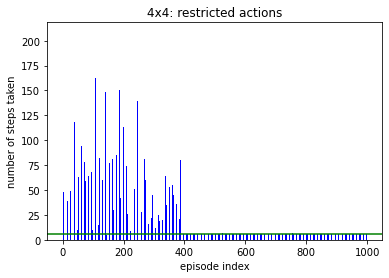

In [20]:
plt.axhline(y=6, color='green', linestyle='-')
plt.bar(np.arange(0, 1000), steps_total, 
        width = 0.4, color = 'blue')
plt.xlabel('episode index')
plt.ylabel('number of steps taken')
plt.title('4x4: restricted actions')
plt.show()

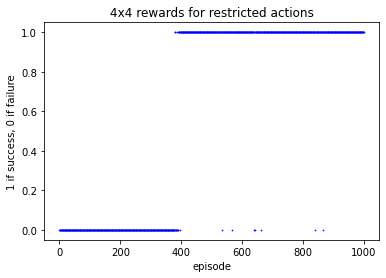

In [21]:

plt.scatter(np.arange(0, 1000), rewards_total, s = 0.5, color = 'blue')
plt.title('4x4 rewards for restricted actions')
plt.xlabel('episode')
plt.ylabel('1 if success, 0 if failure')
plt.show()

In [105]:
##to convert rewards to 1 or 0 when there is a time decay 
##new_rewards_total = [ 1 if i > 0.0 else 0 for i in rewards_total  ]


In [22]:
print(Q)
        
print("Percent of episodes finished successfully: {0}".format(sum(rewards_total)/num_episodes))
print("Percent of episodes finished successfully (last 100 episodes): {0}".format(sum(rewards_total[-100:])/100))

print("Average number of steps: %.2f" % (sum(steps_total)/num_episodes))
print("Average number of steps (last 100 episodes): %.2f" % (sum(steps_total[-100:])/100))


           0         1         2         3
0   0.546367  0.481544  0.590749  0.579091
1   0.630372  0.245025  0.656378  0.315030
2   0.696752  0.729161  0.317190  0.704421
3   0.014811  0.013808  0.014885  0.015170
4   0.016387  0.014824  0.013485  0.526585
5   0.000000  0.000000  0.000000  0.000000
6   0.187726  0.810205  0.189746  0.740896
7   0.000000  0.000000  0.000000  0.000000
8   0.015529  0.005166  0.013922  0.015507
9   0.014288  0.013589  0.730615  0.010453
10  0.165677  0.900021  0.065241  0.831778
11  0.000000  0.000000  0.000000  0.000000
12  0.000000  0.000000  0.000000  0.000000
13  0.010774  0.013947  0.883248  0.013963
14  0.770187  0.945455  1.000041  0.950122
15  0.000000  0.000000  0.000000  0.000000
Percent of episodes finished successfully: 0.605
Percent of episodes finished successfully (last 100 episodes): 1.0
Average number of steps: 25.55
Average number of steps (last 100 episodes): 6.04


In [24]:
##convert Q-table to pandas dataframe to export to excel

In [23]:
Q

,0,1,2,3
0,0.546367,0.481544,0.590749,0.579091
1,0.630372,0.245025,0.656378,0.315030
2,0.696752,0.729161,0.317190,0.704421
3,0.014811,0.013808,0.014885,0.015170
4,0.016387,0.014824,0.013485,0.526585
5,0.000000,0.000000,0.000000,0.000000
6,0.187726,0.810205,0.189746,0.740896
7,0.000000,0.000000,0.000000,0.000000
8,0.015529,0.005166,0.013922,0.015507
9,0.014288,0.013589,0.730615,0.010453
